In [1]:
from keras.models import load_model
from astropy.io import fits
import numpy as np
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import json

Using TensorFlow backend.


In [2]:
basedir = "/scratch/dgandhi/desi/time-domain-bkup/tuning_batch_v2/cnn/categorical/"
models = ["batch(07-18_14:44:48)/iter(17)_run(07-18_14:44:49_511884)/weights/weights.Ep73-ValAcc0.83.hdf5",
          "batch(07-18_14:44:48)/iter(67)_run(07-18_14:44:54_886971)/weights/weights.Ep72-ValAcc0.84.hdf5",
          "batch(07-19_11:36:51)/iter(92)_run(07-19_11:36:55_775852)/weights/weights.Ep75-ValAcc0.87.hdf5",
          "batch(07-19_11:36:51)/iter(64)_run(07-19_11:36:54_667053)/weights/weights.Ep73-ValAcc0.86.hdf5",
          "batch(07-19_11:36:51)/iter(45)_run(07-19_11:36:53_892865)/weights/weights.Ep70-ValAcc0.85.hdf5",
          "batch(07-19_11:36:51)/iter(27)_run(07-19_11:36:53_132799)/weights/weights.Ep73-ValAcc0.85.hdf5",
          "batch(07-20_15:55:00)/iter(47)_run(07-20_15:55:02_573722)/weights/weights.Ep58-ValAcc0.87.hdf5"
         ]

In [4]:
h = fits.open('/scratch/dgandhi/desi/time-domain-bkup/cnn-data/hosts_data.fits')
standardized_hosts = h[0].data
rmags_hosts = h[2].data
h.close()
h = fits.open('/scratch/dgandhi/desi/time-domain-bkup/cnn-data/sne_ia_data.fits')
standardized_ia = h[0].data
rfr_ia = h[2].data
h.close()
h = fits.open('/scratch/dgandhi/desi/time-domain-bkup/cnn-data/sne_iip_data.fits')
standardized_iip = h[0].data
rfr_iip = h[2].data
h.close()

In [7]:
print(standardized_hosts.shape)
print(rmags_hosts.shape)
print(standardized_ia.shape)
print(rfr_ia.shape)
print(standardized_iip.shape)
print(rfr_iip.shape)

(99588, 400)
(99588,)
(99492, 400)
(99492,)
(120155, 400)
(120155,)


In [20]:
test_hosts = standardized_hosts[85000:len(standardized_ia)]
test_ia = standardized_ia[85000:len(standardized_ia)]
test_iip = standardized_iip[85000:len(standardized_ia)]

In [21]:
print(test_hosts.shape, test_ia.shape, test_iip.shape)

(14492, 400) (14492, 400) (14492, 400)


In [36]:
x_test = np.concatenate([test_hosts, test_ia, test_iip]).reshape(-1,400,1)
y_test = np.concatenate([np.zeros(len(test_hosts)), np.ones(len(test_ia)), 1+np.ones(len(test_iip))])
brightest = np.concatenate([rmags_hosts[85000:len(standardized_ia)] <= np.median(rmags_hosts),rfr_ia[85000:len(standardized_ia)] >=0.5, rfr_iip[85000:len(standardized_ia)] >= 0.5 ])


In [23]:
model1 = load_model(basedir + models[-1])

In [24]:
y_pred = model1.predict(x_test)

In [25]:
print(y_pred)
y_pred_labels = np.argmax(y_pred, axis=1)
print(y_pred_labels)

[[9.9704665e-01 2.4548554e-04 2.7079424e-03]
 [8.5906428e-01 5.1010507e-03 1.3583468e-01]
 [9.9991727e-01 7.7290308e-05 5.4870288e-06]
 ...
 [2.0710798e-03 3.4289524e-01 6.5503371e-01]
 [2.3165612e-08 1.0472029e-09 1.0000000e+00]
 [9.0412623e-01 3.6375958e-04 9.5510058e-02]]
[0 0 0 ... 2 2 0]


In [37]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred_labels))
print(accuracy_score(y_test[brightest],y_pred_labels[brightest]))

0.8544024289263041
0.9399944310376833


In [75]:
y_pred_class_hosts = y_pred_labels[:len(test_hosts)]
y_pred_class_ia = y_pred_labels[len(test_hosts):len(test_hosts)+len(test_ia)]
y_pred_class_iip = y_pred_labels[len(test_hosts)+len(test_ia):]

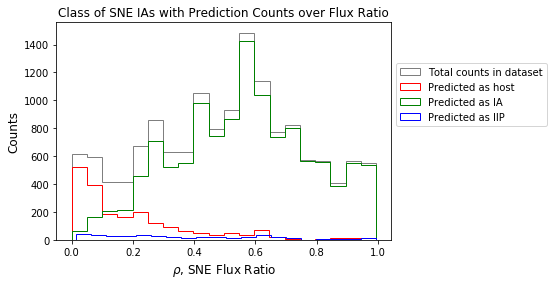

In [78]:
y_pred_class_ia_predicted_hosts = y_pred_class_ia == 0
y_pred_class_ia_predicted_ia = y_pred_class_ia == 1
y_pred_class_ia_predicted_iip = y_pred_class_ia == 2

rfr_ia_test = rfr_ia[85000:len(standardized_ia)]
plt.hist(rfr_ia_test, label="Total counts in dataset", bins=20, histtype='step', color='black', alpha=0.5)
plt.hist(rfr_ia_test[y_pred_class_ia_predicted_hosts], label="Predicted as host", bins=20, histtype='step', color='red')
plt.hist(rfr_ia_test[y_pred_class_ia_predicted_ia], label="Predicted as IA", bins=20, histtype='step', color='green')
plt.hist(rfr_ia_test[y_pred_class_ia_predicted_iip], label="Predicted as IIP", bins=20, histtype='step', color='blue')
plt.xlabel(r'$\rho$, SNE Flux Ratio', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Class of SNE IAs with Prediction Counts over Flux Ratio')
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()

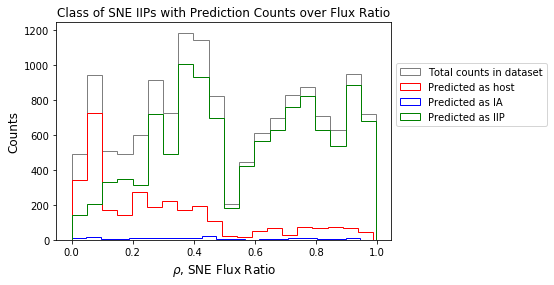

In [80]:
y_pred_class_iip_predicted_hosts = y_pred_class_iip == 0
y_pred_class_iip_predicted_ia = y_pred_class_iip == 1
y_pred_class_iip_predicted_iip = y_pred_class_iip == 2

rfr_iip_test = rfr_iip[85000:len(standardized_ia)]
plt.hist(rfr_iip_test, label="Total counts in dataset", bins=20, histtype='step', color='black', alpha=0.5)
plt.hist(rfr_iip_test[y_pred_class_iip_predicted_hosts], label="Predicted as host", bins=20, histtype='step', color='red')
plt.hist(rfr_iip_test[y_pred_class_iip_predicted_ia], label="Predicted as IA", bins=20, histtype='step', color='blue')
plt.hist(rfr_iip_test[y_pred_class_iip_predicted_iip], label="Predicted as IIP", bins=20, histtype='step', color='green')
plt.xlabel(r'$\rho$, SNE Flux Ratio', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Class of SNE IIPs with Prediction Counts over Flux Ratio')
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()